In [1]:
TASK= "Detection"

In [2]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.utils.model_zoo as model_zoo
import math
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, RandomResizedCrop, ColorJitter, RandomApply, RandomChoice, GaussianBlur
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


cuda


In [3]:
image_shape = (224, 224, 3)
image_size = 224
NUM_WORKERS = os.cpu_count()
mapping = {"mel": 1, "nv": 0, "bcc": 3, "akiec": 4, "bkl": 2, "df": 6, "vasc": 5}

if TASK == "Detection":
    mapping = {"mel": 0, "nv": 1, "bcc": 0, "akiec": 0, "bkl": 1, "df": 1, "vasc": 0}

In [4]:
class DatasetHAM10000(Dataset):
    def __init__(self, img_dir, transforms = None):
        self.transforms=transforms
        self.data = []
        
        self.meta = pd.read_csv('/kaggle/input/ham10004/HAM10000/HAM10000_metadata.csv')
        
        for image_dir in os.listdir(img_dir):
            if image_dir == 'HAM10000_metadata.csv': continue
            
            img_path = os.path.join(img_dir, image_dir)
            
            image_id = os.path.splitext(image_dir)[0]
            meta_row = self.meta[self.meta['image_id'] == image_id]
            if not meta_row.empty:
                label = meta_row.iloc[0]['dx']
                self.data.append([img_path, mapping[label]])
            else:
                print(image_id)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        
        img_path = os.path.join(self.data[idx][0])
        label = self.data[idx][1] 
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            image = Image.new("RGB", (image_size, image_size), (0, 0, 0))
            
        if self.transforms:
            image = self.transforms(image)
            
        return image, label

In [5]:
data_dir = '/kaggle/input/ham10004/HAM10000/HAM10000'

image_shape = (224, 224, 3)
NUM_WORKERS = os.cpu_count()

data_transforms = transforms.Compose([
    transforms.Resize((image_shape[0], image_shape[1])),
    transforms.ToTensor()
])

data = DatasetHAM10000(data_dir, transforms = data_transforms)

train_dataset, test_dataset = train_test_split(data, test_size=0.2, random_state=12345)

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=NUM_WORKERS, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, num_workers=NUM_WORKERS)

print(len(train_dataloader))
print(len(test_dataloader))

251
63


In [17]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

def resnet50():
    model = ResNet(Bottleneck, [3, 4, 6, 3]).to(device)
    model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model

class myResnet(nn.Module):
    def __init__(self):
        super(myResnet, self).__init__()
        self.resnet = resnet50().to(device)
        
        self.fc = nn.Linear(1000, len(mapping))
        
    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)
        
        return x
    
model = myResnet()
model = model.to(device)

print(model)

myResnet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

num_epochs = 50
best_accuracy = 0.0 
best_model_path = '/kaggle/working/best_model.pth'
train_loss_history = []
train_accuracy_history = []

for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    
    all_labels = []
    all_predicted = []

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        inputs = inputs.float().to(device) 
        labels = torch.Tensor(labels).to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    accuracy = round(accuracy_score(all_labels, all_predicted) * 100, 4)
    f1 = round(f1_score(all_labels, all_predicted, average='weighted', zero_division=1) * 100, 4)
    recall = round(recall_score(all_labels, all_predicted, average='weighted', zero_division=1) * 100, 4)
    precision = round(precision_score(all_labels, all_predicted, average='weighted', zero_division=1) * 100, 4)
        
    loss = round((running_loss / (len(train_dataloader))), 4)
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss}, Accuracy: {accuracy}%, F1 Score: {f1}%, Recall: {recall}%, Precision: {precision}%')
    
    train_loss_history.append(loss)
    train_accuracy_history.append(accuracy)
        
print('Training finished')

Epoch 1/50, Loss: 0.4549, Accuracy: 81.6775%, F1 Score: 81.9596%, Recall: 81.6775%, Precision: 82.856%
Epoch 2/50, Loss: 0.2154, Accuracy: 91.4129%, F1 Score: 91.1835%, Recall: 91.4129%, Precision: 91.1631%
Epoch 3/50, Loss: 0.114, Accuracy: 95.9561%, F1 Score: 95.91%, Recall: 95.9561%, Precision: 95.9089%
Epoch 4/50, Loss: 0.0533, Accuracy: 98.4398%, F1 Score: 98.4348%, Recall: 98.4398%, Precision: 98.4337%
Epoch 5/50, Loss: 0.0228, Accuracy: 99.5382%, F1 Score: 99.5377%, Recall: 99.5382%, Precision: 99.5377%
Epoch 6/50, Loss: 0.0165, Accuracy: 99.5382%, F1 Score: 99.5381%, Recall: 99.5382%, Precision: 99.5381%
Epoch 7/50, Loss: 0.0193, Accuracy: 99.3385%, F1 Score: 99.338%, Recall: 99.3385%, Precision: 99.3377%
Epoch 8/50, Loss: 0.0095, Accuracy: 99.7629%, F1 Score: 99.7627%, Recall: 99.7629%, Precision: 99.7627%
Epoch 9/50, Loss: 0.0086, Accuracy: 99.7629%, F1 Score: 99.7629%, Recall: 99.7629%, Precision: 99.7631%
Epoch 10/50, Loss: 0.0082, Accuracy: 99.7753%, F1 Score: 99.7752%, Re

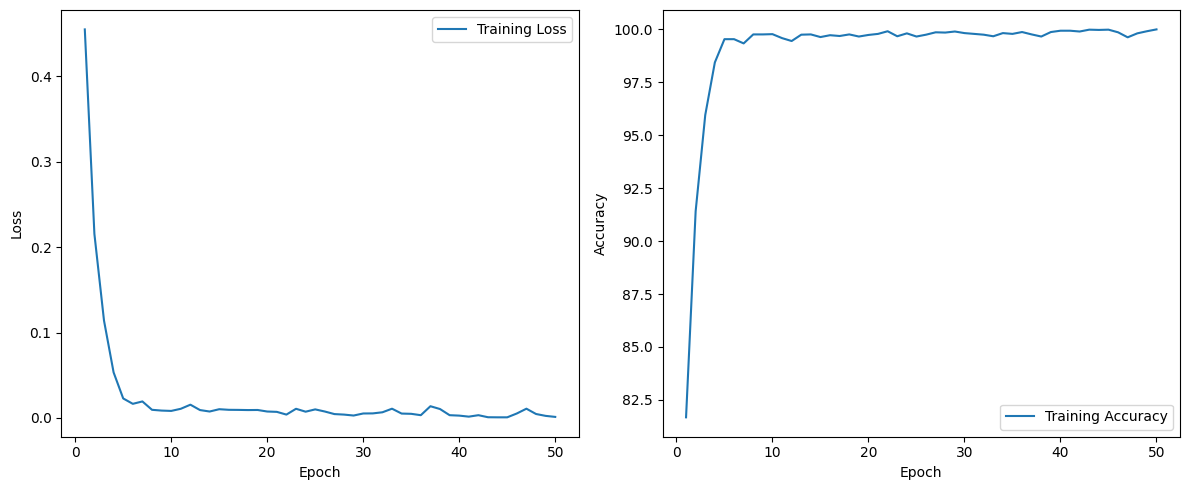

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Đồ thị Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Đồ thị Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Tăng cường mặt định để tránh việc trùng lắp với tiêu đề và nhãn trục
plt.tight_layout()

# Hiển thị đồ thị
plt.show()

In [23]:
model.eval()  

all_labels = []
all_predicted = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        
        inputs = inputs.float().to(device) 
        labels = torch.Tensor(labels).to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

accuracy = round(accuracy_score(all_labels, all_predicted) * 100, 4)
f1 = round(f1_score(all_labels, all_predicted, average='weighted', zero_division=1) * 100, 4)
recall = round(recall_score(all_labels, all_predicted, average='weighted', zero_division=1) * 100, 4)
precision = round(precision_score(all_labels, all_predicted, average='weighted', zero_division=1) * 100, 4)
    
print(f'Accuracy: {accuracy}%, F1 Score: {f1}%, Recall: {recall}%, Precision: {precision}%')

Accuracy: 90.9136%, F1 Score: 90.7207%, Recall: 90.9136%, Precision: 90.656%


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
print(classification_report(all_labels, all_predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.81      0.73      0.77       414
           1       0.93      0.96      0.94      1589

    accuracy                           0.91      2003
   macro avg       0.87      0.84      0.86      2003
weighted avg       0.91      0.91      0.91      2003



ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (7).

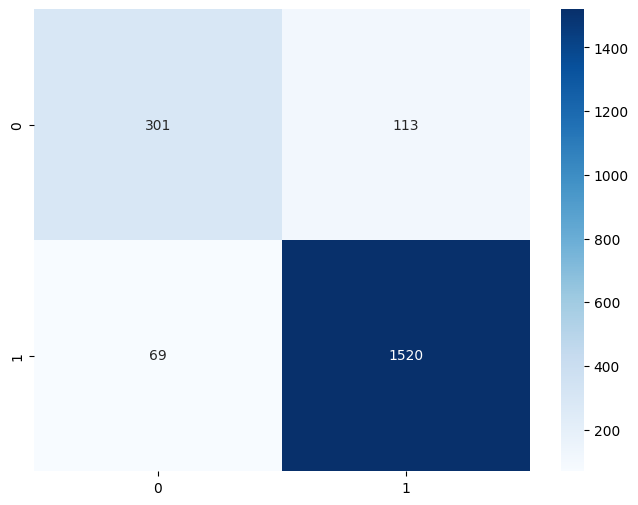

In [13]:
conf_matrix = confusion_matrix(all_labels, all_predicted)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True)

tick_labels = ['Nevus', 'Melanoma', 'BKL', 'BCC', 'AKIEC', 'VASC', 'DF'] 
ax.set_xticklabels(tick_labels, rotation=0)
ax.set_yticklabels(tick_labels, rotation=0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
